In [1]:
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

torch:  1.10 ; cuda:  1.10.0


In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [3]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "test.json", "test_images")
# register_coco_instances("my_dataset_val", {}, "test.json", "test_images")

In [4]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 8  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
# trainer.train()

[02/25 03:54:55 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[02/25 03:54:55 d2.data.datasets.coco]: Loaded 269 images in COCO format from test.json
[02/25 03:54:55 d2.data.build]: Removed 14 images with no usable annotations. 255 images left.
[02/25 03:54:55 d2.data.build]: Distribution of instances among all 8 categories:
|  category  | #instances   |   category    | #instances   |   category    | #instances   |
|:----------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
|   Cracks   | 233          |   Potholes    | 538          |    Patches    | 1            |
|  Sidewalk  | 1            | White Road .. | 2            | Double Yell.. | 1            |
|    Car     | 1            | Alligator C.. | 113          |               |              |
|   total    | 890          |               |              |               |              |
[02/25 03:54:55 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_st

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (9, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (9,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (32, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (32,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (8, 256, 1, 1) 

[02/25 03:55:00 d2.engine.train_loop]: Starting training from iteration 0


c:\users\luope\anaconda3\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


ERROR [02/25 03:55:17 d2.engine.train_loop]: Exception during training:
Traceback (most recent call last):
  File "c:\users\luope\anaconda3\lib\site-packages\detectron2\engine\train_loop.py", line 149, in train
    self.run_step()
  File "c:\users\luope\anaconda3\lib\site-packages\detectron2\engine\defaults.py", line 494, in run_step
    self._trainer.run_step()
  File "c:\users\luope\anaconda3\lib\site-packages\detectron2\engine\train_loop.py", line 285, in run_step
    losses.backward()
  File "c:\users\luope\anaconda3\lib\site-packages\torch\_tensor.py", line 307, in backward
    torch.autograd.backward(self, gradient, retain_graph, create_graph, inputs=inputs)
  File "c:\users\luope\anaconda3\lib\site-packages\torch\autograd\__init__.py", line 156, in backward
    allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag
RuntimeError: CUDA out of memory. Tried to allocate 122.00 MiB (GPU 0; 4.00 GiB total capacity; 1.96 GiB already allocated; 0 bytes free; 2.11 GiB re

RuntimeError: CUDA out of memory. Tried to allocate 122.00 MiB (GPU 0; 4.00 GiB total capacity; 1.96 GiB already allocated; 0 bytes free; 2.11 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [9]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [4]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg = get_cfg()
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

Skip loading parameter 'proposal_generator.rpn_head.conv.weight' to the model due to incompatible shapes: (256, 256, 3, 3) in the checkpoint but (1024, 1024, 3, 3) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.conv.bias' to the model due to incompatible shapes: (256,) in the checkpoint but (1024,) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.objectness_logits.weight' to the model due to incompatible shapes: (3, 256, 1, 1) in the checkpoint but (15, 1024, 1, 1) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.objectness_logits.bias' to the model due to incompatible shapes: (3,) in the checkpoint but (15,) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.anchor_deltas.weight' to the model due to incompatible s

  backbone.bottom_up.res3.0.conv1.weight
  backbone.bottom_up.res3.0.conv1.norm.{bias, running_mean, running_var, weight}
  backbone.bottom_up.res3.0.conv2.weight
  backbone.bottom_up.res3.0.conv2.norm.{bias, running_mean, running_var, weight}
  backbone.bottom_up.res3.0.conv3.weight
  backbone.bottom_up.res3.0.conv3.norm.{bias, running_mean, running_var, weight}
  backbone.bottom_up.res3.1.conv1.weight
  backbone.bottom_up.res3.1.conv1.norm.{bias, running_mean, running_var, weight}
  backbone.bottom_up.res3.1.conv2.weight
  backbone.bottom_up.res3.1.conv2.norm.{bias, running_mean, running_var, weight}
  backbone.bottom_up.res3.1.conv3.weight
  backbone.bottom_up.res3.1.conv3.norm.{bias, running_mean, running_var, weight}
  backbone.bottom_up.res3.2.conv1.weight
  backbone.bottom_up.res3.2.conv1.norm.{bias, running_mean, running_var, weight}
  backbone.bottom_up.res3.2.conv2.weight
  backbone.bottom_up.res3.2.conv2.norm.{bias, running_mean, running_var, weight}
  backbone.bottom_up.res

[01/20 13:46:12 d2.data.datasets.coco]: Loaded 10 images in COCO format from initial_validation_test.json


'\ncfg.DATASETS.TEST = ("microcontroller_test", )\n\ndataset_dicts = get_microcontroller_dicts(\'Microcontroller Segmentation/test\')\nfor d in random.sample(dataset_dicts, 3):    \n    im = cv2.imread(d["file_name"])\n    outputs = predictor(im)\n    v = Visualizer(im[:, :, ::-1],\n                   metadata=microcontroller_metadata, \n                   scale=0.8, \n                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels\n    )\n    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))\n    plt.figure(figsize = (14, 10))\n    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))\n    plt.show()\n'

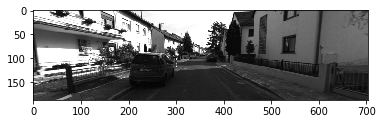

In [7]:
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("my_dataset_val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("my_dataset_val"), 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])
"""
cfg.DATASETS.TEST = ("microcontroller_test", )

dataset_dicts = get_microcontroller_dicts('Microcontroller Segmentation/test')
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=microcontroller_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()
"""

In [8]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[01/20 13:46:16 d2.data.datasets.coco]: Loaded 10 images in COCO format from initial_validation_test.json
[01/20 13:46:16 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|   Crack    | 0            |  Pothole   | 22           |
|            |              |            |              |
|   total    | 22           |            |              |
[01/20 13:46:16 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/20 13:46:16 d2.data.common]: Serializing 10 elements to byte tensors and concatenating them all ...
[01/20 13:46:16 d2.data.common]: Serialized dataset takes 0.01 MiB
[01/20 13:46:16 d2.evaluation.evaluator]: Start inference on 10 batches
[01/20 13:46:22 d2.evaluation.evaluator]: Total inference time: 0:00:00.928844 (0.185769 s / iter pe